<a href="https://colab.research.google.com/github/aveenamagha/Pneumonia-Detection-using-InceptionV3/blob/main/PNEUMONIA_IMAGE_CLASSICIFATION_PROJECT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 # ***Pneumonia Detection Using Deep Learning***

Pneumonia is a lung infection that causes inflammation in the air sacs (alveoli), which can fill with fluid or pus, making breathing difficult. It can be caused by bacteria, viruses, or fungi and is a leading cause of illness worldwide.

# *Why Detect Pneumonia Using Deep Learning?*
Medical imaging, such as chest X-rays, is commonly used to diagnose pneumonia. However, manual diagnosis by doctors can be time-consuming and subjective. Deep learning can help automate pneumonia detection by analyzing X-ray images and predicting whether a patient has NORMAL lungs or PNEUMONIA with high accuracy.

# *Importing necessary libraries*

In [ ]:

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os
import tensorflow as tf
import zipfile
from google.colab import drive
import random
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Input
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array



# *Downloading the Dataset*
Since my dataset is hosted on Kaggle, I need to authenticate and download it. Here's what I did:

1. Uploaded kaggle.json - This file contains my API credentials for accessing Kaggle datasets.

2. Created the Kaggle directory - I moved the JSON file into the appropriate directory for authentication.

3. Set the correct permissions - I made sure the credentials are secure.

4. Downloaded the dataset - I used the kaggle datasets download command to fetch Chest X-ray Pneumonia Dataset from Kaggle.

 Dataset Link: [Chest X-ray Pneumonia](https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia)

In [3]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle (1).json': b'{"username":"aveenamagha","key":"86e00250f11a6ddf4aad9e31adabdffa"}'}

In [ ]:
# Create the Kaggle folder and move the kaggle.json file there
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# Set proper file permissions
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
License(s): other


# *Extracting the Dataset*


In [ ]:
zip_path = '/content/chest-xray-pneumonia.zip'
extract_folder = '/content/chest_xray'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_folder)

print("Dataset extracted.")

Dataset extracted.


 Defining Dataset Paths


1. Training Set (train_dir) – Contains X-ray images used to train the model.
2. Validation Set (val_dir) – Used to fine-tune the model and prevent overfitting.
3. Test Set (test_dir) – Used to evaluate the final model’s performance.

In [ ]:
# Correct paths with the nested folder
train_dir = '/content/chest_xray/chest_xray/train'
val_dir = '/content/chest_xray/chest_xray/val'
test_dir = '/content/chest_xray/chest_xray/test'

 # *Visualizing Example Chest X-rays*
Before diving into model training, I wanted to showcase sample chest X-ray images to help viewers understand the dataset better.

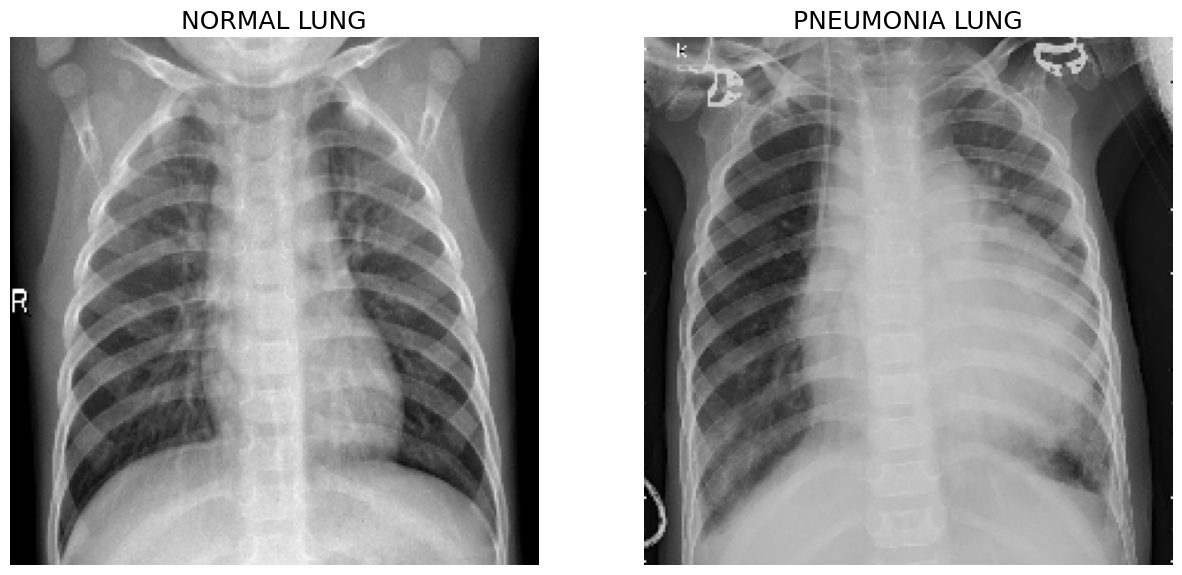

In [ ]:
normal_dir = os.path.join(test_dir, "NORMAL")
pneumonia_dir = os.path.join(test_dir, "PNEUMONIA")

normal_sample = random.choice(os.listdir(normal_dir))
pneumonia_sample = random.choice(os.listdir(pneumonia_dir))

normal_img = load_img(os.path.join(normal_dir, normal_sample), target_size=(224, 224))
pneumonia_img = load_img(os.path.join(pneumonia_dir, pneumonia_sample), target_size=(224, 224))

fig, axes = plt.subplots(1, 2, figsize=(15, 7))
axes[0].imshow(normal_img)
axes[0].set_title("NORMAL LUNG", fontsize=18)
axes[0].axis("off")

axes[1].imshow(pneumonia_img)
axes[1].set_title("PNEUMONIA LUNG", fontsize=18)
axes[1].axis("off")

plt.show()


 Normal Lung X-ray

1. Appears clear and dark because normal lungs are filled with air.
2. The heart and diaphragm are clearly visible with no obstructions.


 Pneumonia Lung X-ray


1. Shows white cloudy patches or opacities due to infection and fluid build-up.
2. The lung fields appear hazy or denser in affected areas.

This visualization helps in understanding how pneumonia affects lung structure and why deep learning models can classify them effectively!



#  *Preparing the Dataset*

Before training the model, I needed to process the dataset properly by applying data augmentation and normalization.

# 1. *Data Augmentation (for the training set)*

*  Rotation – Randomly rotates images up to 30°
*  Shifting – Moves images slightly in width and height
*  Shearing & Zooming – Adds perspective variation
*  Horizontal Flipping – Flips images randomly

# 2. *Rescaling (for all sets)*
Since pixel values in raw images range from 0 to 255, I rescaled them to 0 to 1 for faster and stable training.

# 3. *Loading Data*
I used flow_from_directory() to load images efficiently and ensure they are categorized properly for binary classification (Normal vs Pneumonia).

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1.0/255)
test_datagen = ImageDataGenerator(rescale=1.0/255)

train_ds = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

val_ds = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

test_ds = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

print("Datasets loaded successfully!")

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Datasets loaded successfully!


# *Dataset Summary*
🔹 Total Images in the Dataset: 5216 + 16 + 624 = 5856

🔹 Classes: The dataset contains two categories:

NORMAL (Healthy Lungs)

PNEUMONIA (Infected Lungs)


# ***InceptionV3***
InceptionV3 is a deep learning model developed by Google for image classification tasks. It is an advanced Convolutional Neural Network (CNN) that improves accuracy while keeping computations efficient.
1. We load InceptionV3 without the top classification layer (include_top=False).
2. The input size is (224, 224, 3), meaning it processes color images of size 224x224 pixels.
3. It is initialized with ImageNet weights, so it already understands basic image features like edges, textures, and patterns.

In [ ]:
# Use InceptionV3 as the base model
base_model_inception = InceptionV3(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet')


In [ ]:
base_model_inception.summary()

Model: "inception_v3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_94 (Conv2D)        │ (None, 111, 111, 32)   │            864 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_94    │ (None, 111, 111, 32)   │             96 │ conv2d_94[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_94             │ (None, 111, 111, 32)   │              0 │ batch_normalization_9… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_95 (Conv2D)        │ (None, 109, 109, 32)   │          9,216 │ activation_94[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_95    │ (None, 109, 109, 32)   │             96 │ conv2d_95[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_95             │ (None, 109, 109, 32)   │              0 │ batch_normalization_9… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_96 (Conv2D)        │ (None, 109, 109, 64)   │         18,432 │ activation_95[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_96    │ (None, 109, 109, 64)   │            192 │ conv2d_96[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_96             │ (None, 109, 109, 64)   │              0 │ batch_normalization_9… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_4           │ (None, 54, 54, 64)     │              0 │ activation_96[0][0]    │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_97 (Conv2D)        │ (None, 54, 54, 80)     │          5,120 │ max_pooling2d_4[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_97    │ (None, 54, 54, 80)     │            240 │ conv2d_97[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_97             │ (None, 54, 54, 80)     │              0 │ batch_normalization_9… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_98 (Conv2D)   

 Total params: 21,802,784 (83.17 MB)

 Trainable params: 21,768,352 (83.04 MB)

 Non-trainable params: 34,432 (134.50 KB)

# *Fine-Tuning the Model*

Since InceptionV3 is already trained on a large dataset, we don’t need to train all layers from scratch. Instead, we fine-tune only the last 100 layers to adapt it for pneumonia detection.

Steps Taken:

1. Kept first layers frozen (Retains pretrained knowledge)
2. Unfrozen the last 100 layers (Allows model to learn pneumonia-specific features)
3. Added new layers:

Global Average Pooling (Reduces feature map size)

Dense Layer (128 neurons, ReLU Activation) (Learns patterns from images)

Dropout (0.5) (Prevents overfitting)

Output Layer (Sigmoid Activation) (Binary classification: NORMAL vs PNEUMONIA)

In [ ]:
# Fine-tuning last 100 layers
for layer in base_model_inception.layers[-100:]:
    layer.trainable = True

inputs = Input(shape=(224, 224, 3))
x = base_model_inception(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(1, activation='sigmoid')(x)

model_inception = Model(inputs, output)


# *Model Compilation & Training*

I compiled the model using the Adam optimizer with a small learning rate (1e-5) to fine-tune the pretrained layers. Since this is a binary classification (NORMAL vs PNEUMONIA), I used binary cross-entropy as the loss function and tracked accuracy as the evaluation metric.

To prevent overfitting, I applied EarlyStopping, which stops training if val_loss doesn't improve for 5 epochs.

Finally, I trained the model for 20 epochs using the training and validation datasets, with early stopping ensuring efficient learning. 🚀

In [ ]:
# Compile the model
model_inception.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [ ]:
# Early stopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)


In [ ]:
# Train the model
history_inception = model_inception.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=[early_stopping],
    verbose=1
)



Epoch 1/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 185s 718ms/step - accuracy: 0.6777 - loss: 0.5758 - val_accuracy: 0.5625 - val_loss: 0.7419
Epoch 2/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 109s 670ms/step - accuracy: 0.9129 - loss: 0.2284 - val_accuracy: 0.5625 - val_loss: 1.1396
Epoch 3/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 111s 679ms/step - accuracy: 0.9439 - loss: 0.1750 - val_accuracy: 0.5625 - val_loss: 0.9757
Epoch 4/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 110s 675ms/step - accuracy: 0.9492 - loss: 0.1329 - val_accuracy: 0.8125 - val_loss: 0.4598
Epoch 5/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 110s 676ms/step - accuracy: 0.9558 - loss: 0.1247 - val_accuracy: 0.8125 - val_loss: 0.3609
Epoch 6/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 110s 672ms/step - accuracy: 0.9549 - loss: 0.1199 - val_accuracy: 0.8125 - val_loss: 0.3396
Epoch 7/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 112s 686ms/step - accuracy: 0.9667 - loss: 0.0910 - val_accuracy: 0.8125 - val_loss: 0.3213
Epoch 8/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 109s 667ms/step - accuracy: 0.9650 -

The model started with **67.77%** accuracy and improved rapidly, reaching **98.88%** training accuracy and **100%** validation accuracy by the final epoch. The validation loss decreased significantly, indicating good generalization.

## ***Model Evaluation***

In [ ]:
# Evaluate the model on the test set
test_loss, test_accuracy = model_inception.evaluate(test_ds)
print(f"Test Accuracy: {test_accuracy*100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")

20/20 ━━━━━━━━━━━━━━━━━━━━ 8s 266ms/step - accuracy: 0.9189 - loss: 0.2151
Test Accuracy: 91.03%
Test Loss: 0.2280


The model achieved a test accuracy of **91.03%** with a test loss of **0.2280**, confirming strong performance in detecting pneumonia from chest X-ray images. This indicates that the model generalizes well to unseen data.

In [ ]:

drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
model_inception.save('/content/drive/MyDrive/inception_model_best.keras')


In [ ]:
# Load the saved model
model_inception = load_model('/content/drive/MyDrive/inception_model_best.keras')


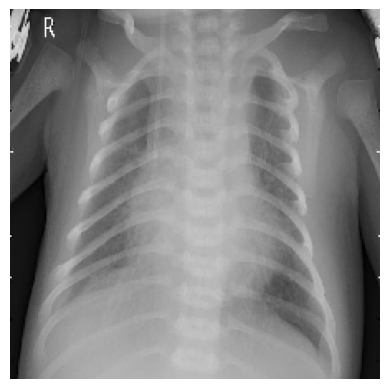

In [ ]:
# testing a single image
test_images, test_labels = next(test_ds)

test_image = test_images[3]
test_label = test_labels[3]

plt.imshow((test_image * 255).astype("uint8"))
plt.axis("off")
plt.show()




In [ ]:
print(test_ds.class_indices)


{'NORMAL': 0, 'PNEUMONIA': 1}


In [ ]:
test_image_expanded = np.expand_dims(test_image, axis=0)

prediction = model_inception.predict(test_image_expanded)

# Convert prediction to class label
predicted_class = (prediction > 0.5).astype("int")[0][0]

class_labels = ["NORMAL", "PNEUMONIA"]

print(f"Actual Class: {class_labels[int(test_label)]}")
print(f"Predicted Class: {class_labels[predicted_class]}")

if predicted_class == int(test_label):
    print("The model predicted correctly!")
else:
    print("The model predicted incorrectly.")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Actual Class: NORMAL
Predicted Class: NORMAL
The model predicted correctly!


# ***Summary of Model Testing and Prediction***

The trained model was evaluated on the test dataset, achieving 91.03% accuracy with a test loss of 0.2280, indicating strong performance. To further validate the model, a single test image was selected and displayed. The image was preprocessed to match the model’s input requirements and fed into the model for prediction.


Key Steps in Testing

1. Loaded and evaluated the model – Achieved 91.03% accuracy on the test dataset.
2. Selected a test image – Picked an image from the test dataset for individual testing.
3. Displayed the image – Used Matplotlib to visualize the selected test sample.
4. Preprocessed the image – Resized and expanded dimensions to match the model’s input format.
5. Made a prediction – The model classified the image as NORMAL or PNEUMONIA.


**The model correctly classified the image as NORMAL, matching the actual label from the dataset. This confirms that the model generalizes well to unseen data.**
